# Integrate simulations and experimental data

In this notebook we refine the MD simulation to match experimental data using the Bayesian/MaxEnt approach ([BME](https://www.biorxiv.org/content/10.1101/457952v1.abstract)). In brief, what we use as input is:

1. A set of experimental constraints ${F_1^{exp} ... F_m^{exp}}$ and associated errors ${\sigma_1... \sigma_m}$
2. The experimental observables back-calculated for each of the $n$ frames in the simulation ($F(x_j)_{i}^{calc}, i=1...m, j=1...n$)
3. The initial weights $w^0_1...w^0_n$. In a plain MD simulation the initial weights are uniform ($w_i=1/n$), but we here use metadynamics, and the weights are given by $w^0_j \propto \exp( V(x_j)/kbt)$, where $V$is the final bias potential. The appendix at the end of this notebook describes how to calculate the bias using Plumed. 

The output of the procedure is a new set of weights ${w_1...w_n}$ that are such that the new averages $<F_i^{calc}> = \sum_j^n w_j F(x_j)_{i}^{calc} \approx F_i^{exp} $. Clearly, the new weights can be used to calculate any desired quantity or distribution. 

These steps are largely automatized by our BME script, that can be found [here](https://github.com/KULL-Centre/BME). In essence, the user has to perform the following actions:

```
# initialize the class, specifying the initial weights (if non-uniform)
rew = bme.Reweight(w0=bias,kbt=kbt)
# load the experimental and back-calculated data files
rew.load(exp,calc)
# Run the optimization. A regularization parameter, theta, has to be specified
chi2_before,chi2_after,effective_frames = rew.optimize(theta=t)
# Calculate new averages with the new weights. Note that the exp and calc can be the original 
data used as input (training set), or new data (cross-validation or test set)
# statistics are written to a file
chi = rew.weight_exp(exp,calc,out_filename)
```



In [19]:
import sys
import numpy as np
import os
# add BME to the path (should be changed and depends where the BME script is located)
sys.path.append('/home/sbottaro/Software/python_lib/BME/')
import bme_reweight as bme

# set the intial weights from metadynamics. The bias is passed along with kbt, so 
# that the initial weights are set proportional to exp(bias/kbt)
kbt = 0.008314462*280
bias = [float(line.split()[1]) for line in open("data/bias") if "#" not in line]

# this is a list of available data
lista = [["set_A1","eNOE","eNOE_unidir","gn_eNOE"],\
        ["set_B","NOE","RDC","J3"],\
        ["set_C","RDC1","RDC2"],\
        ["set_D","sPRE"]]

lista = [["set_D","sPRE"]]

thetas =  [5,6,8,10,12.5,15,17.5,20,25,30,35,40,\
           45,50,60,70,80,90,100,250,500,750,1000,2000]
thetas = thetas[::-1]

%mkdir -p data/comparison_p
%mkdir -p data/comparison_p/set_A0
%mkdir -p data/comparison_p/set_A1
%mkdir -p data/comparison_p/set_B
%mkdir -p data/comparison_p/set_C
%mkdir -p data/comparison_p/set_D

       

We choose the regularization parameter theta for each dataset by 10-fold cross-validation. First, we randomly select the 20% of the data from each dataset (which it will be used for training), while the rest is used for validation

In [9]:
# generate random row indeces that will be used later. 

train_fraction = 0.8
n_iterations = 10
columns = [[[] for j in range(len(lista[i])-1) ] for i in range(len(lista))]
for i in range(len(lista)):
    for j in range(1,len(lista[i])):
        for it in range(n_iterations):
            exp = "data/%s/%s.exp.dat" % (lista[i][0],lista[i][j])
            calc = "data/%s/%s.calc.dat" % (lista[i][0],lista[i][j])
            ll = sum([1 for line in open(exp) if "#" not in line])
            rr = np.arange(ll)
            np.random.shuffle(rr)
            columns[i][j-1].append(rr[:int(train_fraction*ll)])
            
            


In [ ]:
import multiprocessing as mp
pool = mp.Pool(mp.cpu_count())
print(mp.cpu_count())

def calc(t):
    for it in range(n_iterations):
        
        # initialize
        rew= bme.Reweight(w0=bias,kbt=kbt)
        
        for j in range(1,len(lista[i])):
            # define experimental and calculated datafile                                                                                                 
            exp = "data/%s/%s.exp.dat" % (lista[i][0],lista[i][j])
            calc = "data/%s/%s.calc.dat" % (lista[i][0],lista[i][j])
            # here we specify the columns (training examples that should be used)
            rew.load(exp,calc,cols=columns[i][j-1][it])
            
        # reweight
        before,after,neff = rew.optimize(theta=t)

        # calculate chi 
        for j in range(1,len(lista[i])):
            # define experimental and calculated datafile                                                                                                 
            exp = "data/%s/%s.exp.dat" % (lista[i][0],lista[i][j])
            calc = "data/%s/%s.calc.dat" % (lista[i][0],lista[i][j])
            ll = sum([1 for line in open(exp) if "#" not in line])
             # calculate chi on training set
            chi = rew.weight_exp(exp,calc,"data/comparison_p/%s/rw_%s_%s_theta_%d_%s" %\
                                     (lista[i][0],lista[i][0],lista[i][j],t,it),cols=columns[i][j-1][it])
            # calculate chi on validation set
            reverse = [k for k in range(ll) if k not in columns[i][j-1][it]]
            chi_r = rew.weight_exp(exp,calc,"data/comparison_p/%s/rw_%s_%s_theta_%d_%s_rev" %\
                                    (lista[i][0],lista[i][0],lista[i][j],t,it),cols=reverse)
        
        

results = []

# here we analyse only sPRE. Change the line below to analyse other datasets
lista = [["set_D","sPRE"]]
for i in range(len(lista)):

        # loop over thetas  
    result_objects = pool.map(calc, [t for t in thetas])

# Assuming weights given as minus free energies. w=exp(bias/kbt) kbt=  2.3280 
# Assuming weights given as minus free energies. w=exp(bias/kbt) kbt=  2.3280 
# Assuming weights given as minus free energies. w=exp(bias/kbt) kbt=  2.3280 
# Assuming weights given as minus free energies. w=exp(bias/kbt) kbt=  2.3280 
# Assuming weights given as minus free energies. w=exp(bias/kbt) kbt=  2.3280 
# Assuming weights given as minus free energies. w=exp(bias/kbt) kbt=  2.3280 
# Assuming weights given as minus free energies. w=exp(bias/kbt) kbt=  2.3280 
# Assuming weights given as minus free energies. w=exp(bias/kbt) kbt=  2.3280 
# Assuming weights given as minus free energies. w=exp(bias/kbt) kbt=  2.3280 
# Assuming weights given as minus free energies. w=exp(bias/kbt) kbt=  2.3280 
# Assuming weights given as minus free energies. w=exp(bias/kbt) kbt=  2.3280 
# Assuming weights given as minus free energies. w=exp(bias/kbt) kbt=  2.3280 
# Assuming weights given as minus free energies. w=e

# $\theta$ selection

For each dataset, we run the optimization 10 times with a different set of training experimental data. We plot below the average training and validation $\chi^2$ for different values of $\theta$. A vertical, dashed line indicates the value of theta that is used for each dataset. 

(4, 24, 10, 5)
Theta selected:  20.0
Effective fraction:  12.8


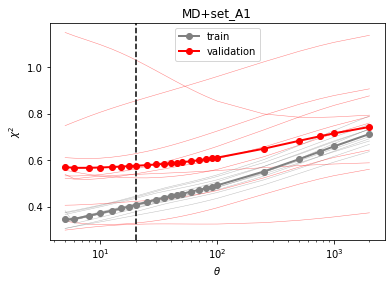

Theta selected:  50.0
Effective fraction:  26.8


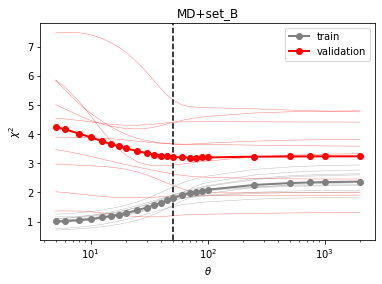

Theta selected:  60.0
Effective fraction:  10.1


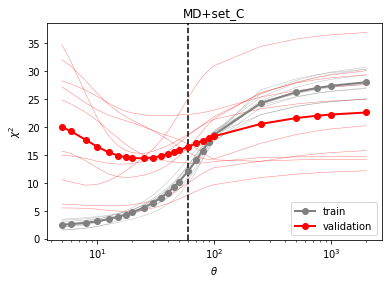

Theta selected:  500.0
Effective fraction:  9.9


/home/sbottaro/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:59: RuntimeWarning: Mean of empty slice
/home/sbottaro/anaconda3/envs/py36/lib/python3.6/site-packages/ipykernel_launcher.py:60: RuntimeWarning: Mean of empty slice


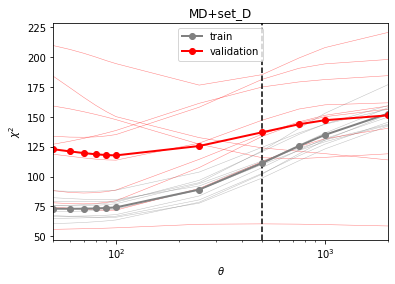

In [33]:
import glob
import numpy as np                                                                                                   

dd = ["set_A1","set_B","set_C","set_D"]
nrep = 10

def calc_chi(mm):
    
    ll = glob.glob(mm)

    if(len(ll)==0):
        return np.nan, np.nan,0.0
    ntot = 0
    chi2_a_tot,chi2_b_tot = 0.,0.
    for el in ll:
        fh = open(el)
        data = fh.readlines()
        nn = sum([1 for kk in data if "#" not in kk])
        chi2_b_tot += (float(data[-1].split()[-2])*nn)
        chi2_a_tot += (float(data[-1].split()[-1])*nn)
        ntot += nn
        neff=np.exp(float(data[0].split("=")[-1]))
    return chi2_b_tot/ntot, chi2_a_tot/ntot,neff

data = np.zeros((len(dd),len(thetas),nrep,5))

for i,d in enumerate(dd):
    for j,t in enumerate(thetas):
        for k in range(nrep):
            mm = "data/comparison_p/%s/rw_%s_*_theta_%d_%d.stats.dat" % (d,d,t,k)
            chi2_b_tot_train, chi2_a_tot_train,neff = calc_chi(mm)
            mm = "data/comparison_p/%s/rw_%s_*_theta_%d_%d_rev.stats.dat" % (d,d,t,k)
            chi2_b_tot_val, chi2_a_tot_val,neff1 = calc_chi(mm)

            data[i,j,k,0] = chi2_b_tot_train
            data[i,j,k,1] = chi2_a_tot_train
            data[i,j,k,2] = chi2_b_tot_val
            data[i,j,k,3] = chi2_a_tot_val
            data[i,j,k,4] = neff1
print(data.shape)

import matplotlib.pyplot as plt
theta_select = [20,50,60,500]

for i in range(data.shape[0]):
    for j in range(data.shape[2]):
        plt.plot(thetas,data[i,:,j,3],c='r',alpha=0.5,lw=0.5)
        plt.plot(thetas,data[i,:,j,1],c='0.5',alpha=0.5,lw=0.5)

    neff_mean = np.nanmean(data[i,:,:,4],axis=1)
    idx = np.abs(np.array(thetas) - theta_select[i]).argmin()
    #plt.plot(thetas,np.nanmean(data[i,:,:,4],axis=1),"o-",label="train",c='y')                                                                               
    print("Theta selected: % 4.1f" % theta_select[i])
    print("Effective fraction: % 4.1f" % (100*neff_mean[idx]))
    
    #for k in range(len(thetas)):
    #    print("%5.1f %5.3f %5.3f" % (thetas[k],neff_mean[k],np.nanmean(data[i,:,:,3],axis=1)[k]))
    plt.axvline(theta_select[i],c='k',ls='--')
    plt.plot(thetas,np.nanmean(data[i,:,:,1],axis=1),"o-",label="train",c='0.5',lw=2)
    plt.plot(thetas,np.nanmean(data[i,:,:,3],axis=1),"o-",label="validation",c='r',lw=2)
    plt.legend()
    plt.xscale('log')
    #plt.yscale('log')                                                                                                                                        
    #plt.xlim(0,500)                                                                                                                                          
    plt.savefig("plot_%d.png" % i)
    plt.xlabel(r"$\theta$")
    plt.title("MD+%s" % dd[i])
    plt.ylabel(r'$\chi^2$')
    if(i==3): plt.xlim(50,2000)
    plt.show()
    plt.close()


In [ ]:
%mkdir -p data/comparison_n
%mkdir -p data/comparison_n/set_A0
%mkdir -p data/comparison_n/set_A1
%mkdir -p data/comparison_n/set_B
%mkdir -p data/comparison_n/set_C
%mkdir -p data/comparison_n/set_D

In [39]:
# this is a list of available data
lista = [["set_A1","eNOE","eNOE_unidir","gn_eNOE"],\
        ["set_B","NOE","RDC","J3"],\
        ["set_C","RDC1","RDC2"],\
        ["set_D","sPRE"]]


nblocks = 4
bsize = int(len(bias)/nblocks)

theta_select = [20,50,60,500]


for i in range(len(lista)):
    
    for p in range(nblocks):
 
        start = p*bsize
        stop = start+bsize

        rew= bme.Reweight(w0=bias,kbt=kbt)
        for j in range(1,len(lista[i])):
            exp_c = "data/%s/%s.exp.dat" % (lista[i][0],lista[i][j])
            calc_c = "data/%s/%s.calc.dat" % (lista[i][0],lista[i][j])
            rew.load(exp_c,calc_c,rows=range(start,stop))
            
        # Optimize
        before,after,neff = rew.optimize(theta=theta_select[i])
            
        # print weights to file
        w_opt = rew.get_weights()
        w_0 = np.exp(np.array(bias)[range(start,stop)]/kbt)
        w_0 /= np.sum(w_0)
        stri = ""
        for ii in range(len(w_opt)):
            stri += "%10.4e %10.4e \n" % (w_0[ii],w_opt[ii])
        fhw = open("data/weights_%s_t_%d_rep_%d.dat" % (lista[i][0],theta_select[i],p),"w")
        fhw.write(stri)
        fhw.close()
    
        # now loop over the other experimental data for cross-validation
        for l in range(len(lista)):
            for m in range(1,len(lista[l])):
                exp_c = "data/%s/%s.exp.dat" % (lista[l][0],lista[l][m])
                calc_c = "data/%s/%s.calc.dat" % (lista[l][0],lista[l][m])
                chi = rew.weight_exp(exp_c,calc_c,\
                                 "data/comparison_n/%s/rw_%s_%s_theta_%d_rep_%d"\
                                  % (lista[i][0],lista[l][0],lista[l][m],theta_select[i],p),rows=range(start,stop))
                
    
    # do it again, to get weights wihtout bins - useful for 2d projections
    rew= bme.Reweight(w0=bias,kbt=kbt)
    for j in range(1,len(lista[i])):
        exp_c = "data/%s/%s.exp.dat" % (lista[i][0],lista[i][j])
        calc_c = "data/%s/%s.calc.dat" % (lista[i][0],lista[i][j])
        rew.load(exp_c,calc_c)
           
    # Optimize
    before,after,neff = rew.optimize(theta=theta_select[i])
    w_opt = rew.get_weights()
    w_0 = np.exp(np.array(bias)/kbt)
    w_0 /= np.sum(w_0)
    stri = ""
    for ii in range(len(w_opt)):
        stri += "%10.4e %10.4e \n" % (w_0[ii],w_opt[ii])
    fhw = open("data/weights_%s_t_%d.dat" % (lista[i][0],theta_select[i]),"w")
    fhw.write(stri)
    fhw.close()   

# Assuming weights given as minus free energies. w=exp(bias/kbt) kbt=  2.3280 
# Set non-uniform initial weights from file. Sum= 11503.331447473747 100001
# Warning: expt average         G2_H1;C13_H6=7.9748e-05 is larger than maximum value in simulation 4.0578e-05
# Warning: expt average        U11_H3;U11_H6=1.7960e-04 is larger than maximum value in simulation 1.0253e-04
# Warning: expt average         C5_H41;C5_H6=3.1401e-05 is smaller than minimum value in simulation 3.4807e-05
# Warning: expt average      C13_H1';C13_H3'=1.4759e-04 is smaller than minimum value in simulation 2.0084e-04
# Warning: expt average         C5_H4';C5_H6=5.0814e-04 is larger than maximum value in simulation 4.4971e-04
# Warning: expt average       G10_H4';G10_H8=5.0814e-04 is larger than maximum value in simulation 3.7553e-04
# Warning: expt average         C3_H1';C3_H6=2.2001e-04 is smaller than minimum value in simulation 2.5787e-04
# Warning: expt average        C3_H1';C3_H2'=8.5647e-04 is smaller than 

# Warning: expt average        G1_H3';G1_H5'=2.1300e-04 is smaller than minimum value in simulation 2.1332e-04
# Warning: expt average         C3_H1';C3_H6=2.2001e-04 is smaller than minimum value in simulation 2.5693e-04
# Warning: expt average        C3_H1';C3_H2'=8.5647e-04 is smaller than minimum value in simulation 8.9282e-04
# Warning: expt average        C3_H1';C3_H4'=2.8683e-04 is smaller than minimum value in simulation 2.8936e-04
# Warning: expt average         A4_H1';A4_H8=1.1375e-04 is smaller than minimum value in simulation 2.0058e-04
# Warning: expt average        A4_H1';A4_H2'=6.7424e-04 is smaller than minimum value in simulation 9.6466e-04
# Warning: expt average        A4_H1';A4_H3'=1.5557e-04 is smaller than minimum value in simulation 1.8249e-04
# Warning: expt average        A4_H1';A4_H4'=2.1300e-04 is smaller than minimum value in simulation 2.8829e-04
# Warning: expt average        U7_H1';U7_H2'=3.7857e-04 is smaller than minimum value in simulation 8.6651e-04
#

# RDC scaling factor 6.9135e-01
# Warning: expt average              11-2H5P=0.0000e+00 is smaller than minimum value in simulation 9.9199e-01
# Warning: expt average               3-1H5P=0.0000e+00 is smaller than minimum value in simulation 9.9199e-01
# Warning: expt average             G9-2H5H4=-4.6000e+00 is smaller than minimum value in simulation -8.3505e-02
# Warning: expt average             U6-1H5H4=-6.0000e-01 is smaller than minimum value in simulation -8.3505e-02
# Warning: expt average             C8-1H5H4=-3.0000e-01 is smaller than minimum value in simulation -8.3505e-02
# Warning: expt average             G9-1H5H4=-2.8000e+00 is smaller than minimum value in simulation -8.3505e-02
# Warning: expt average            U11-1H5H4=-9.0000e-01 is smaller than minimum value in simulation -8.3505e-02
# Warning: expt average            C13-1H5H4=-1.7000e+00 is smaller than minimum value in simulation -8.3505e-02
# Warning: expt average            C14-1H5H4=-8.0000e-01 is smaller 

# RDC scaling factors 6.5480e-01, 7.6142e-01
# RDC scaling factors 1.0142e+00, 1.1488e+00
# RDC scaling factors 5.7153e-01, 7.0122e-01
# RDC scaling factors 6.1197e-03, 6.1962e-03
# Assuming weights given as minus free energies. w=exp(bias/kbt) kbt=  2.3280 
# Set non-uniform initial weights from file. Sum= 11503.331447473747 100001
# Warning: expt average         G2_H1;C3_H42=4.1957e-03 is larger than maximum value in simulation 3.7354e-03
# Warning: expt average        G2_H1';G2_H2'=6.7551e-03 is larger than maximum value in simulation 6.1478e-03
# Warning: expt average        A4_H1';C5_H1'=1.2181e-03 is larger than maximum value in simulation 3.1302e-04
# Warning: expt average        A4_H1';A4_H3'=2.1202e-03 is larger than maximum value in simulation 6.9933e-04
# Warning: expt average        A4_H61;A4_H62=6.4132e-03 is smaller than minimum value in simulation 2.1540e-02
# Warning: expt average       C5_H3';C5_HO2'=1.0834e-04 is smaller than minimum value in simulation 1.4686e-04
# W

# RDC scaling factors 6.9135e-01, 7.4518e-01
# RDC scaling factors 1.0043e+00, 1.1135e+00
# RDC scaling factors 6.1683e-01, 6.6939e-01
# RDC scaling factors 6.1923e-03, 6.3891e-03
# Assuming weights given as minus free energies. w=exp(bias/kbt) kbt=  2.3280 
# Set non-uniform initial weights from file. Sum= 11503.331447473747 100001
# RDC scaling factor 6.2253e-03
# Warning: expt average              1GuaH4'=1.2939e+00 is larger than maximum value in simulation 1.2473e+00
# Warning: expt average               1GuaH8=1.7188e+00 is larger than maximum value in simulation 1.4919e+00
# Warning: expt average              3CytH41=6.9691e-02 is smaller than minimum value in simulation 9.2582e-02
# Warning: expt average              3CytH42=7.7233e-02 is smaller than minimum value in simulation 8.9899e-02
# Warning: expt average              4AdeH61=7.4677e-03 is smaller than minimum value in simulation 8.9463e-02
# Warning: expt average              4AdeH62=-4.8206e-03 is smaller than minimum

# appendix: calculating the final bias potential for each frame

A first step we take the average HILLS file

`bash ../script/medie.sh < data/HILLS.0 200000 1000000 > data/HILLS.0.avg`

Then, calculate the bias for each frame using the following `plumed.weights.dat` file.

    RESTART
    MOLINFO STRUCTURE=uucg_gmx.pdb
    WHOLEMOLECULES ENTITY0=1-447
    ee3: ERMSD ATOMS=@lcs-1,@lcs-2,@lcs-3,@lcs-4,@lcs-5,@lcs-6,@lcs-7,@lcs-8,@lcs-9,@lcs-10,@lcs-11,@lcs-12,@lcs-13,@lcs-14 REFERENCE=2koc_gmx.pdb CUTOFF=3.2
    metad: METAD ARG=ee3 PACE=500000001 HEIGHT=0.0 SIGMA=0.1 FILE=HILLS.0.avg TEMP=280 BIASFACTOR=15 GRID_MIN=0.0 GRID_MAX=6.0
    bias: REWEIGHT_BIAS TEMP=280
    PRINT ARG=metad.bias FILE=bias STRIDE=1 RESTART=NO

And run plumed driver

`plumed driver --plumed plumed.weights.dat --mf_xtc traj_temp_f_0.xtc`


This produces a file `bias` that contains the averaged final bias, and the weights can be estimated as $w_i \propto exp(bias/kt)$